In [8]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import os
from astropy.io import fits

np.random.seed(1)
# Hubble constant
h = 0.7

nside = 128
npix = hp.nside2npix(nside)

# We will make two bins (z_photo < 0.15 and z_photo > 0.15)
nbins = 2
nz_h = 50
zsplit = 0.15

# This will contain the N(z) of the different bins
nz_tot = np.zeros([nbins, nz_h])
sigz = 0.03

# These will be the density and ellipticity maps
dmap = np.zeros([nbins, npix])
e1map = np.zeros([nbins, npix])
e2map = np.zeros([nbins, npix])

# Now we loop over all source files
ifile = 0
while os.path.isfile('out_srcs_s1_%d.fits' % ifile):
    print("HI")
    hdulist = fits.open('out_srcs_s1_%d.fits' % ifile)
    d = hdulist[1].data
    n_g = len(d)

    # Generate random photo-z
    z_photo = d['Z_COSMO'] + sigz*(1+d['Z_COSMO'])*np.random.randn(n_g)

    # Split into 2
    msk1 = z_photo <= zsplit
    msk2 = z_photo > zsplit

    # For each bin, add to the number and ellipticity maps
    for ibin, msk in enumerate([msk1, msk2]):
        dd = d[msk]

        pix = hp.ang2pix(nside,
                         np.radians(90-dd['DEC']),
                         np.radians(dd['RA']))
        n = np.bincount(pix, minlength=npix)
        e1 = np.bincount(pix, minlength=npix, weights=dd['E1'])
        e2 = np.bincount(pix, minlength=npix, weights=dd['E2'])
        dmap[ibin, :] += n
        e1map[ibin, :] += e1
        e2map[ibin, :] += e2

        # Add also to N(z)
        nz, z_edges = np.histogram(dd['Z_COSMO'], bins=nz_h,
                                   range=[0., 0.5])
        nz_tot[ibin, :] += nz
    ifile += 1

# Midpoint of N(z) histogram
z_nz = 0.5*(z_edges[1:] + z_edges[:-1])

# Compute <e> map and overdensity map
# Compute also shot noise level
shotnoise = np.zeros(nbins)
for ib in range(nbins):
    ndens = (np.sum(dmap[ib])+0.0)/(4*np.pi)
    shotnoise[ib] = 1./ndens
    e1map[ib, :] = e1map[ib]/dmap[ib]
    e1map[ib, dmap[ib] <= 0] = 0
    e2map[ib, :] = e2map[ib]/dmap[ib]
    e2map[ib, dmap[ib] <= 0] = 0
    dmap[ib, :] = (dmap[ib, :] + 0.0) / np.mean(dmap[ib] + 0.0) - 1

# Read P(k) theory prediction
zs = []
pks_dd = []
pks_dm = []
pks_mm = []
z_pk = 0.
while os.path.isfile("out_pk_srcs_pop0_z%.3lf.txt" % z_pk):
    ks, pdd, pdm, pmm = np.loadtxt("out_pk_srcs_pop0_z%.3lf.txt" % z_pk, unpack=True)
    # The delta-delta prediction involves some Fourier transforms that make it unstable
    # at high-k, so we just set it to zero.
    pdd[pmm<1E-30] = 0
    pks_dd.append(pdd)
    pks_dm.append(pdm)
    pks_mm.append(pmm)
    zs.append(z_pk)
    z_pk += 0.1
# Reverse order (because CCL needs increasing scale factor - not redshift).
# Also, CCL uses non-h units.
zs = np.array(zs)[::-1]
ks = np.array(ks) * h
pks_dd = np.array(pks_dd)[::-1, :] / h**3
pks_dm = np.array(pks_dm)[::-1, :] / h**3
pks_mm = np.array(pks_mm)[::-1, :] / h**3

# Create CCL P(k) structures
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=h, n_s=0.96, sigma8=0.8)
pk2d_dd = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_dd,
                   is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
pk2d_dm = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_dm,
                   is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
pk2d_mm = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_mm,
                   is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
# These can be evaluated as follows:
print(pk2d_dd.eval(k=0.1, a=1/(1+0.2), cosmo=cosmo))

# Create a number counts and a weak lensing tracer for each of the bins
tr_d = [ccl.NumberCountsTracer(cosmo, False, (z_nz, nz_tot[i]), bias=(z_nz, np.ones_like(z_nz)))
        for i in range(nbins)]
tr_l = [ccl.WeakLensingTracer(cosmo, (z_nz, nz_tot[i])) for i in range(nbins)]

# Compute power spectra. I'm only doing delta-delta here.
pairs=[(0,0), (0,1), (1,1)]
cl_dd_d = np.array([hp.anafast(dmap[p1], dmap[p2]) for p1, p2 in pairs])
larr = np.arange(3*nside)
cl_dd_t = np.array([ccl.angular_cl(cosmo, tr_d[p1], tr_d[p2], larr, p_of_k_a=pk2d_mm)
                    for p1, p2 in pairs])

HI


<ipython-input-8-f6a601750643>:73: RuntimeWarning: invalid value encountered in true_divide
  e1map[ib, :] = e1map[ib]/dmap[ib]
<ipython-input-8-f6a601750643>:75: RuntimeWarning: invalid value encountered in true_divide
  e2map[ib, :] = e2map[ib]/dmap[ib]


5316.327616572224


In [9]:
all_objects = larr, pairs, shotnoise, cl_dd_d, cl_dd_t, nz_tot, z_nz

In [10]:
import pickle

In [11]:
with open('all_data.pkl','wb') as output:
    pickle.dump(all_objects, output)

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import os
from astropy.io import fits
import pickle

In [6]:
with open('all_data.pkl','rb') as input:
    larr, pairs, shotnoise, cl_dd_d, cl_dd_t, nz_tot, z_nz = pickle.load(input)

In [7]:
nside = 128

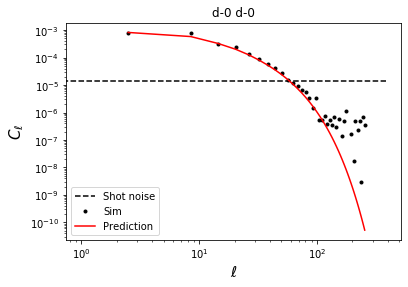

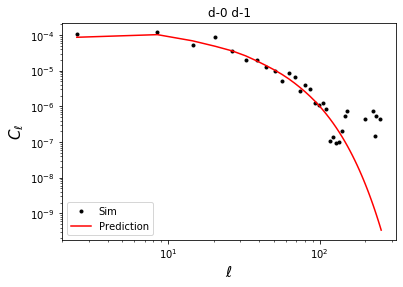

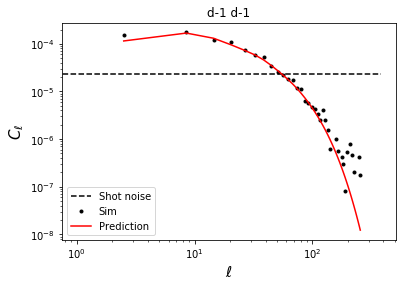

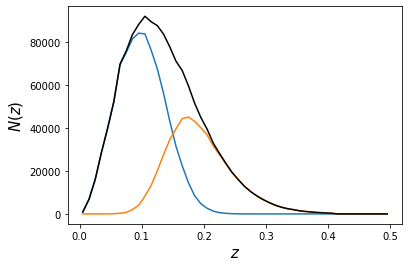

In [3]:
# Compare C_ells with theory
for i, (p1, p2) in enumerate(pairs):
    plt.figure()
    plt.title('d-%d d-%d' % (p1, p2))
    if p1 == p2:
        nl = shotnoise[p1]
        plt.plot(larr, nl*np.ones_like(larr), 'k--', label='Shot noise')
    else:
        nl = 0

    # Rebin to reduce noise
    cld = np.mean((cl_dd_d[i]-nl).reshape([-1, 6]), axis=1)
    clt = np.mean(cl_dd_t[i].reshape([-1, 6]), axis=1)
    l = np.mean(larr.reshape([-1, 6]), axis=1)
    msk = l<2*nside
    plt.plot(l[msk], cld[msk], 'k.', label='Sim')
    plt.plot(l[msk], clt[msk], 'r-', label='Prediction')
    plt.loglog()
    plt.xlabel(r'$\ell$', fontsize=15)
    plt.ylabel(r'$C_\ell$', fontsize=15)
    plt.legend(loc='lower left')

# Plot N(z)s
plt.figure()
for n in nz_tot:
    plt.plot(z_nz, n)
plt.plot(z_nz, np.sum(nz_tot, axis=0), 'k-')
plt.xlabel(r'$z$', fontsize=15)
plt.ylabel(r'$N(z)$', fontsize=15)
plt.show()

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import os
from astropy.io import fits

sim_path = '/global/homes/c/cramirez/Codes/CoLoRe_analysis/CoLoRe_analysis/tests/test_sims/New_CCL'
output_path = 'ccl_data/'

In [7]:
# Hubble constant
h = 0.7

nside = 128
npix = hp.nside2npix(nside)

# We will make two bins (z_photo < 0.15 and z_photo > 0.15)
nbins = 2
nz_h = 50
zsplit = 0.15

# This will contain the N(z) of the different bins
nz_tot = np.zeros([nbins, nz_h])
sigz = 0.03

# These will be the density and ellipticity maps
dmap = np.zeros([nbins, npix])
e1map = np.zeros([nbins, npix])
e2map = np.zeros([nbins, npix])

# Now we loop over all source files
ifile = 0
while os.path.isfile(sim_path + '/out_srcs_s1_%d.fits' % ifile):
    hdulist = fits.open(sim_path + '/out_srcs_s1_%d.fits' % ifile)
    d = hdulist[1].data
    n_g = len(d)

    # Generate random photo-z
    z_photo = d['Z_COSMO'] + sigz*(1+d['Z_COSMO'])*np.random.randn(n_g)

    # Split into 2
    msk1 = z_photo <= zsplit
    msk2 = z_photo > zsplit

    # For each bin, add to the number and ellipticity maps
    for ibin, msk in enumerate([msk1, msk2]):
        dd = d[msk]

        pix = hp.ang2pix(nside,
                        np.radians(90-dd['DEC']),
                        np.radians(dd['RA']))
        n = np.bincount(pix, minlength=npix)
        e1 = np.bincount(pix, minlength=npix, weights=dd['E1'])
        e2 = np.bincount(pix, minlength=npix, weights=dd['E2'])
        dmap[ibin, :] += n
        e1map[ibin, :] += e1
        e2map[ibin, :] += e2

        # Add also to N(z)
        nz, z_edges = np.histogram(dd['Z_COSMO'], bins=nz_h,
                                range=[0., 0.5])
        nz_tot[ibin, :] += nz
    ifile += 1

# Midpoint of N(z) histogram
z_nz = 0.5*(z_edges[1:] + z_edges[:-1])

# Compute <e> map and overdensity map
# Compute also shot noise level
shotnoise = np.zeros(nbins)
for ib in range(nbins):
    ndens = (np.sum(dmap[ib])+0.0)/(4*np.pi)
    shotnoise[ib] = 1./ndens
    e1map[ib, :] = e1map[ib]/dmap[ib]
    e1map[ib, dmap[ib] <= 0] = 0
    e2map[ib, :] = e2map[ib]/dmap[ib]
    e2map[ib, dmap[ib] <= 0] = 0
    dmap[ib, :] = (dmap[ib, :] + 0.0) / np.mean(dmap[ib] + 0.0) - 1

# Read P(k) theory prediction
zs = []
pks_dd = []
pks_dm = []
pks_mm = []
z_pk = 0.
while os.path.isfile(sim_path + "/out_pk_srcs_pop0_z%.3lf.txt" % z_pk):
    ks, pdd, pdm, pmm = np.loadtxt(sim_path + "/out_pk_srcs_pop0_z%.3lf.txt" % z_pk, unpack=True)
    # The delta-delta prediction involves some Fourier transforms that make it unstable
    # at high-k, so we just set it to zero.
    pdd[pmm<1E-30] = 0
    pks_dd.append(pdd)
    pks_dm.append(pdm)
    pks_mm.append(pmm)
    zs.append(z_pk)
    z_pk += 0.1
# Reverse order (because CCL needs increasing scale factor - not redshift).
# Also, CCL uses non-h units.
zs = np.array(zs)[::-1]
ks = np.array(ks) * h
pks_dd = np.array(pks_dd)[::-1, :] / h**3
pks_dm = np.array(pks_dm)[::-1, :] / h**3
pks_mm = np.array(pks_mm)[::-1, :] / h**3

# Create CCL P(k) structures
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=h, n_s=0.96, sigma8=0.8)
pk2d_dd = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_dd,
                is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
pk2d_dm = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_dm,
                is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
pk2d_mm = ccl.Pk2D(a_arr=1./(1+zs), lk_arr=np.log(ks), pk_arr=pks_mm,
                is_logp=False, extrap_order_hik=0, extrap_order_lok=0)
# These can be evaluated as follows:
print(pk2d_dd.eval(k=0.1, a=1/(1+0.2), cosmo=cosmo))

# Create a number counts and a weak lensing tracer for each of the bins
tr_d = [ccl.NumberCountsTracer(cosmo, False, (z_nz, nz_tot[i]), bias=(z_nz, np.ones_like(z_nz)))
        for i in range(nbins)]
tr_l = [ccl.WeakLensingTracer(cosmo, (z_nz, nz_tot[i])) for i in range(nbins)]

# Compute power spectra. I'm only doing delta-delta here.
pairs=[(0,0), (0,1), (1,1)]
cl_dd_d = np.array([hp.anafast(dmap[p1], dmap[p2]) for p1, p2 in pairs])
larr = np.arange(3*nside)
cl_dd_t = np.array([ccl.angular_cl(cosmo, tr_d[p1], tr_d[p2], larr, p_of_k_a=pk2d_mm)
                    for p1, p2 in pairs])

<ipython-input-7-b71c52020411>:64: RuntimeWarning: invalid value encountered in true_divide
  e1map[ib, :] = e1map[ib]/dmap[ib]
<ipython-input-7-b71c52020411>:66: RuntimeWarning: invalid value encountered in true_divide
  e2map[ib, :] = e2map[ib]/dmap[ib]


5316.327616572224


In [5]:
cl_dd_t

NameError: name 'cl_dd_t' is not defined